# How to prepare delicious triaxial haloes: three years after
Looking back at my first paper ([shameless plug](https://ui.adsabs.harvard.edu/#abs/2015MNRAS.449.3171B/abstract)) I though: who's this person doing this terrible analysis?

Let's see what I've learned in the last 3 years.

###### Note: that I will ignore the fact that I should be doing everything using the quantity $\nu$. Instead I will use the mass, which at fixed redshift is a proxy of $\nu$

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pystan
import corner

from astropy import cosmology

p_mass = 6.174e9
m_star = 5.8e12

In [2]:
haloes = pd.read_hdf( 'mxxl_shapes_063_1e13.hdf5', 'EO' )

haloes.head()

Mvir      Rvir            x            y            z        dx  \
0  227927.0  3.131027  2038.446411   581.613708  2328.402832 -0.007059   
1  222422.0  5.730528  1979.157349   521.141113  2259.114502  0.408958   
2  186094.0  3.609769  2023.364258   577.740540  2293.031006 -0.052191   
3  102819.0  3.061513  1979.132324   527.956177  2285.942139  0.080144   
4  123207.0  4.324922  2922.420410  1548.702637  1695.184692 -0.083630   

         dy        dz         c         b  ...         c0        c1        c2  \
0  0.173667 -0.207504  1.035203  0.714810  ...  -0.259129  0.685636 -0.680262   
1  0.806627  0.098679  2.061256  0.683817  ...   0.375715  0.833728  0.404642   
2  0.061655  0.220492  1.008657  0.556139  ...  -0.185410  0.558433  0.808564   
3 -0.009473 -0.211835  0.990111  0.546407  ...  -0.324872  0.335225  0.884355   
4 -0.331589  0.108571  1.562672  0.734248  ...   0.662926 -0.246622 -0.706900   

         b0        b1        b2        a0        a1        a2  iter  
0  0.665068  0.637406  0.389099 -0.700383  0.351593  0.621165   1.0  
1 -0.243290 -0.332582  0.911153  0.894230 -0.440779  0.077882   1.0  
2 -0.187222  0.787683 -0.586944  0.964661  0.260206  0.041493   1.0  
3  0.163417  0.940907 -0.296629  0.931533 -0.048153  0.360455   1.0  
4  0.074455  0.961224 -0.265527  0.744974  0.123392  0.655582   1.0  

[5 rows x 21 columns]

Cleaning the catalogue from unrelaxed haloes.

In [3]:
offset = haloes['dx']**2 + haloes['dx']**2 + haloes['dx']**2
haloes = haloes[ offset < 0.05 * haloes['Rvir'] ].copy()

haloes['Mvir'] = haloes['Mvir'] * p_mass
haloes['lM'] = np.log10( haloes['Mvir'] / m_star )
haloes['q'] = haloes['b'] / haloes['c']
haloes['s'] = haloes['a'] / haloes['c']
haloes['q_scaled'] = ( haloes['q'] - haloes['s'] ) / ( 1 - haloes['s'] )

haloes.shape

(7325999, 25)

<IPython.core.display.Javascript object>


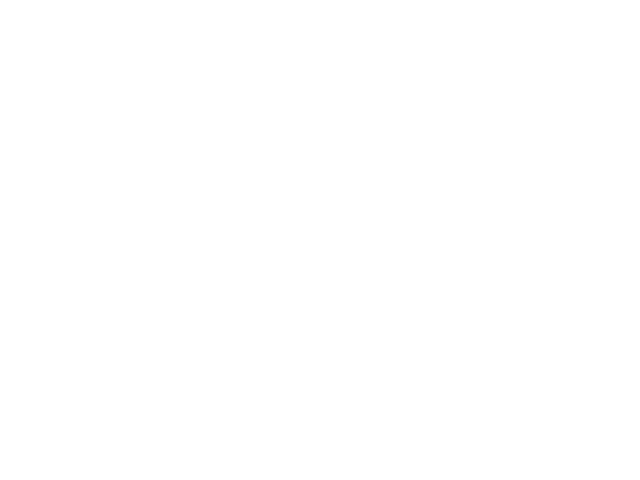

In [4]:
plt.close('all')
#plt.hist( np.log10( haloes['Mvir'] ), bins=20, histtype='step', label='s', log=True );
plt.hist( haloes['lM'], bins=20, histtype='step', label='s', log=True );



In [5]:
mbins = np.arange( 13.0, 15.8, 0.2 )

haloes['M_bin'] = np.digitize( haloes['Mvir'], 10**mbins )

<IPython.core.display.Javascript object>


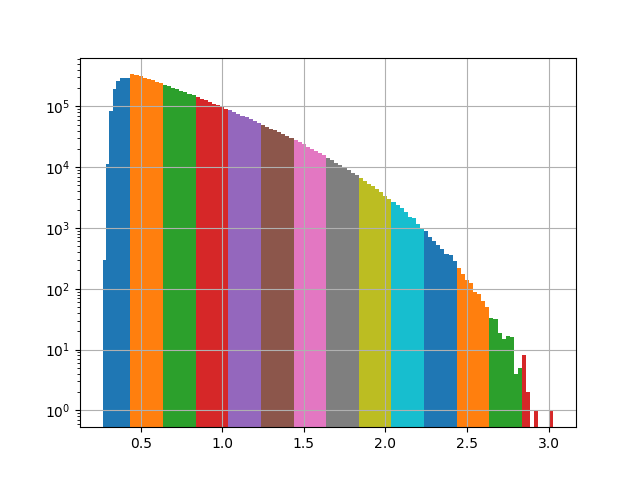

In [6]:
plt.close('all')

lM_groupedby_M = haloes.groupby( 'M_bin' )['lM']
lM_groupedby_M.hist( bins=8, log=True );

This here is the trend we want to reproduce: how the shape parameter $s$ depends on the halo mass, we might want to put cut at lower masses, due to resolution effects

<IPython.core.display.Javascript object>


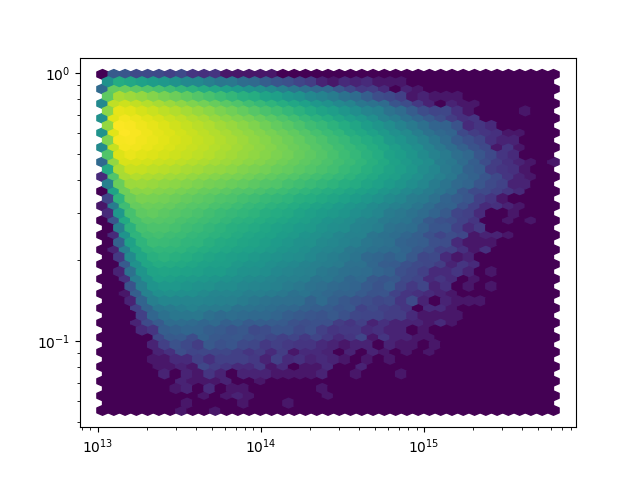

In [10]:
plt.close('all')

plt.hexbin( haloes['Mvir'], haloes['s'], gridsize=40, bins='log', xscale='log', yscale='log' )

# High mass haloes

I have changed a bit the model and implemented a first version in Stan.

For high masses, there should be no dependence of the intrinsic scatter distribution on the mass (or at least a very weak one). Also we should use less haloes for testing, just to speed up things 

In [10]:
# Number of haloes to use
Nhaloes = 1000

high_mass_haloes = haloes[ haloes['Mvir'] > 1e14 ].copy()

ids = np.arange( len( high_mass_haloes ) )
np.random.shuffle( ids )
high_mass_haloes = high_mass_haloes.iloc[ids[:Nhaloes]].copy()



In [11]:
s_code = """
data {
    int<lower=0> N;          // number of haloes
    real lM[N];              // log halo mass
    real ls[N];              // predicted log axis ratio s
}
parameters {
    real a;
    real b;
    real<lower=0> sigmas; // std of log axis ratio s
}
transformed parameters {
    real mus[N];
    for (i in 1:N)
    mus[i]= b + a * lM[i];
}
model {
    ls ~ normal( mus, sigmas );
}
"""

s_data = { 'N': len(high_mass_haloes),
           'lM': np.log10( high_mass_haloes['Mvir'] / m_star ),
           'ls': np.log10( high_mass_haloes['s'] ), }

sm = pystan.StanModel( model_code=s_code )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_75fc4ae0f5818f942f774a61a62db81c NOW.


In [14]:
fit = sm.sampling( data=s_data, iter=10000, chains=4)

<IPython.core.display.Javascript object>


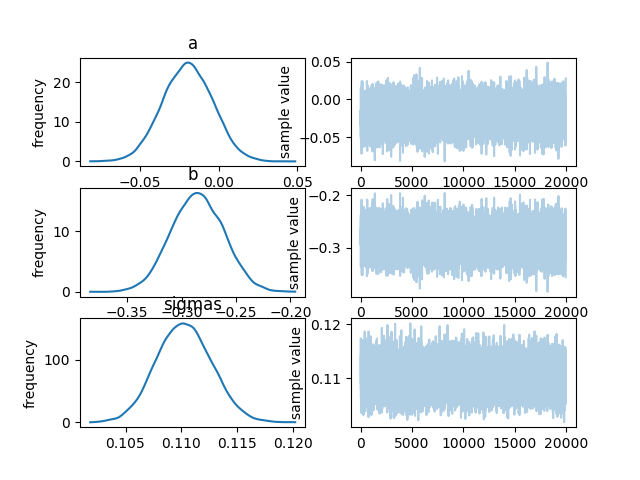

In [15]:
plt.close('all')

fit.plot(['a','b','sigmas']);

(20000, 3)


<IPython.core.display.Javascript object>


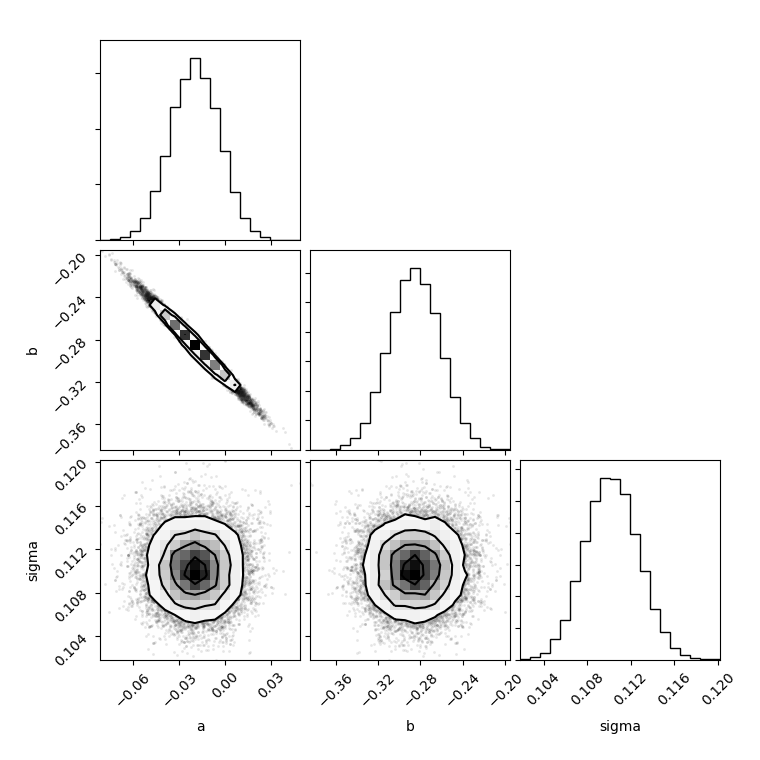

In [16]:
## return an array of three dimensions: iterations, chains, parameters
chains = fit.extract(permuted=False)
chains = chains.reshape( (-1, chains.shape[-1]) )[:,:3]
print( chains.shape )

plt.close('all')
corner.corner( chains, labels=('a', 'b', 'sigma') );

-0.0197190522858 -0.285533281412


<IPython.core.display.Javascript object>


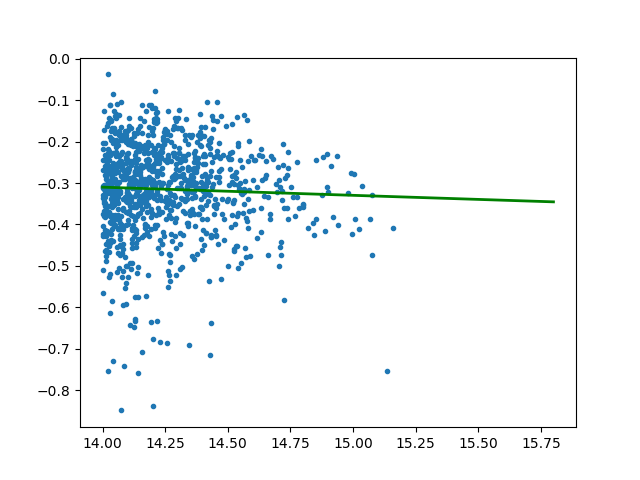

In [19]:
la = fit.extract()

a_med = np.median( la['a'] )
b_med = np.median( la['b'] )

print( a_med, b_med )


plt.close('all')

plt.plot( np.log10( high_mass_haloes['Mvir'] ), np.log10( high_mass_haloes['s'] ), '.' )

xx = np.linspace( 14., 15.8, 100 )
plt.plot( xx, b_med + a_med * ( xx - np.log10( m_star ) ), 'g-', lw=2 )

<IPython.core.display.Javascript object>


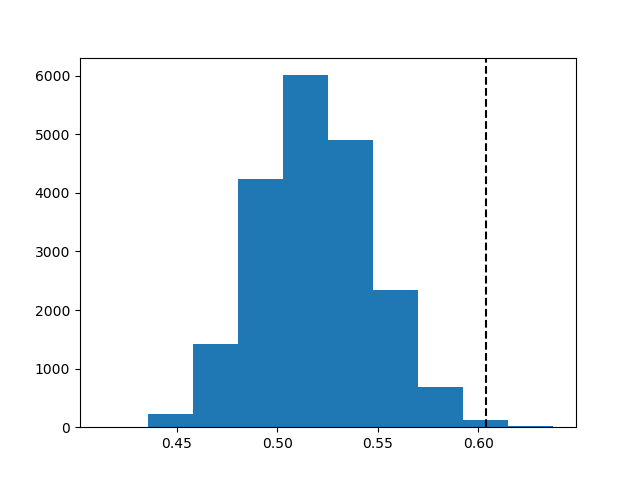

In [20]:
plt.close('all')

plt.hist( 10**( la['b'] + la['a'] * np.log10( 5.8e12 / m_star )  ) )

plt.axvline( 0.604, c='k', ls='--' )

# All haloes

Let's try with all the masses. Again, we should use less haloes for testing, just to speed up things 

In [21]:
# Number of haloes to use
Nhaloes = 1000

#all_mass_haloes = haloes[ haloes['Mvir'] > 1e14 ].copy()

ids = np.arange( len( haloes ) )
np.random.shuffle( ids )
all_mass_haloes = haloes.iloc[ids[:Nhaloes]].copy()



In [22]:
s_all_code = """
data {
    int<lower=0> N;          // number of haloes
    real lM[N];              // log halo mass
    real ls[N];              // predicted log axis ratio s
}
parameters {
    real<upper=0> a_mu;
    real<lower=0> b_mu;
    real<lower=0> a_beta;
    real<lower=0> b_beta;
}
transformed parameters {
    real<lower=0,upper=1> mu_s[N];
    real<lower=0> alpha_s[N];
    real<lower=0> beta_s[N];
    for (i in 1:N){
        mu_s[i]= b_mu + a_mu * lM[i];
        beta_s[i]= 10^( b_beta + a_beta * lM[i] );
        alpha_s[i]= beta_s[i] * mu_s[i] / ( 1. - mu_s[i] );
    }
}
model {
    ls ~ beta( alpha_s, beta_s );
}
"""

s_all_data = { 'N': len( all_mass_haloes ),
           'lM': np.log10( all_mass_haloes['Mvir'] / m_star ),
           'ls': all_mass_haloes['s'], }

sm = pystan.StanModel( model_code=s_all_code )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3dd46561bf376c5b1ec8aa65e4369b5 NOW.


In [26]:
fit = sm.sampling( data=s_all_data, iter=1000, chains=4 )

<IPython.core.display.Javascript object>


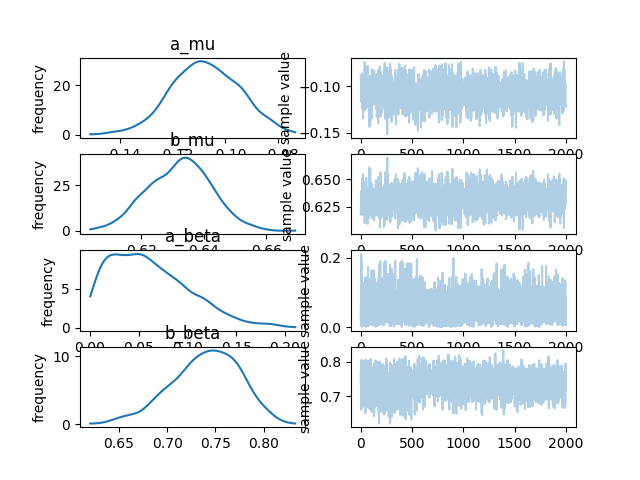

In [27]:
plt.close('all')

parameters = ['a_mu','b_mu','a_beta','b_beta']
fit.plot( parameters );

(2000, 4)


<IPython.core.display.Javascript object>


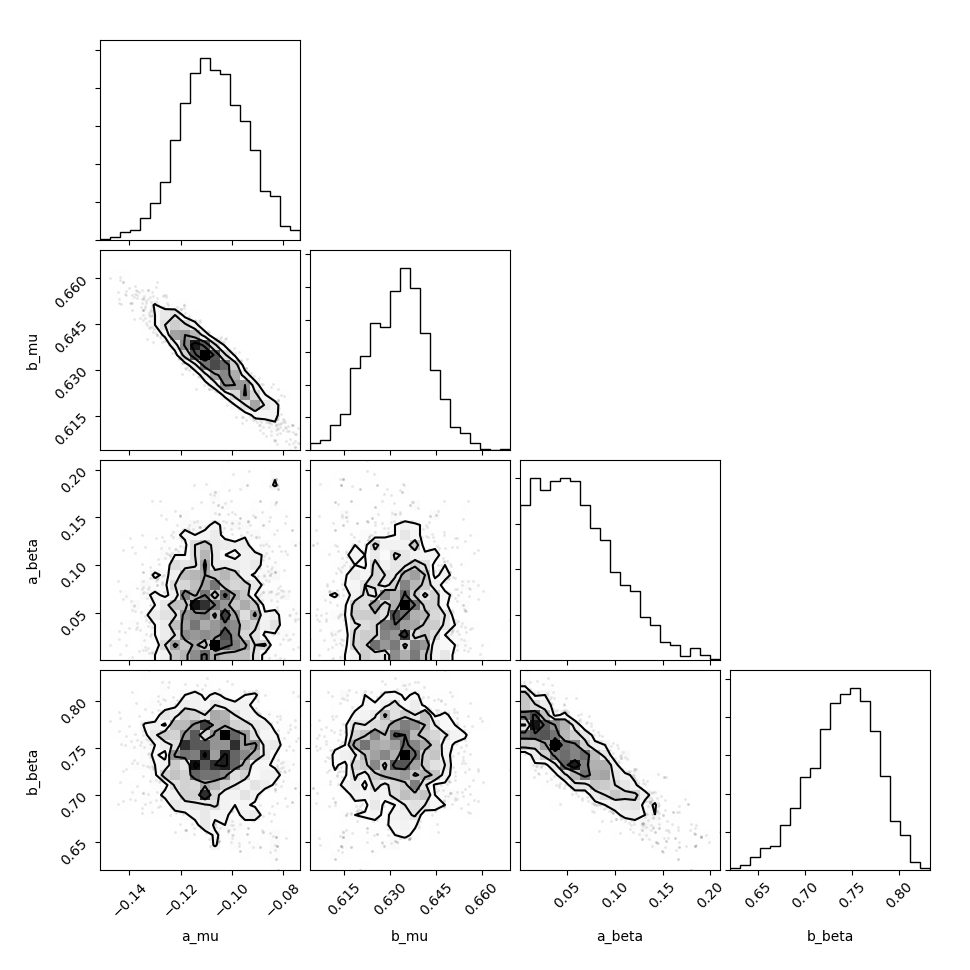

In [28]:
## return an array of three dimensions: iterations, chains, parameters
chains = fit.extract(permuted=False)
chains = chains.reshape( (-1, chains.shape[-1]) )[:,:4]
print( chains.shape )

plt.close('all')
corner.corner( chains, labels=parameters );

In [29]:
la = fit.extract()

a_mu = np.median( la['a_mu'] )
b_mu = np.median( la['b_mu'] )
a_beta = np.median( la['a_beta'] )
b_beta = np.median( la['b_beta'] )

print( a_med, b_med )

-0.0197190522858 -0.285533281412


<IPython.core.display.Javascript object>


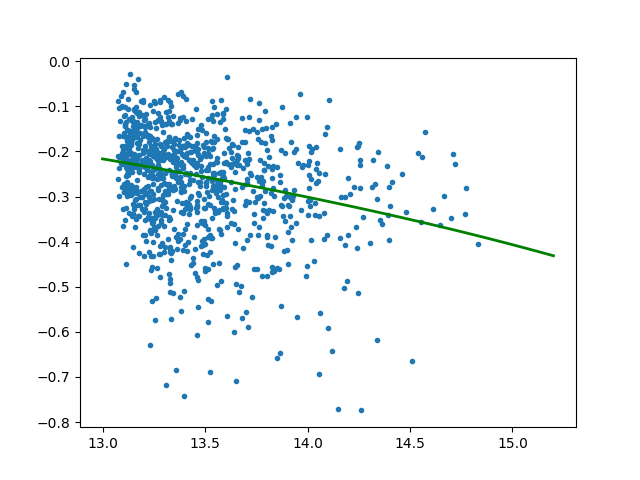

In [33]:
plt.close('all')

plt.plot( np.log10( all_mass_haloes['Mvir'] ), np.log10( all_mass_haloes['s'] ), '.' )

xx = np.linspace( 13., 15.2, 100 )

plt.plot( xx, np.log10( b_mu +  a_mu * ( xx - np.log10(m_star) ) ), 'g-', lw=2 )

<IPython.core.display.Javascript object>


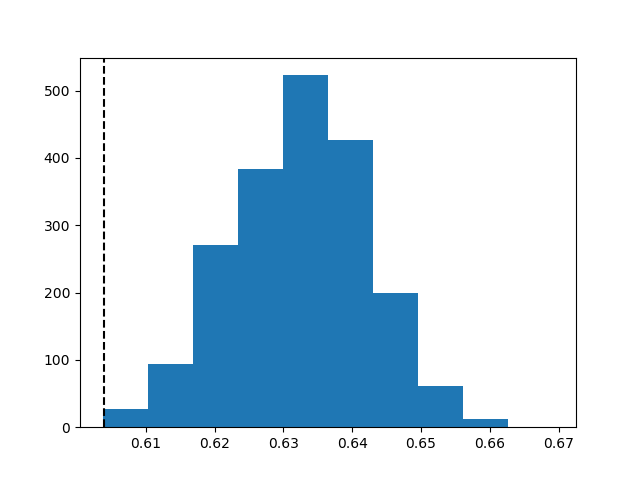

In [37]:
plt.close('all')

plt.hist( la['b_mu']  )

plt.axvline( 0.604, c='k', ls='--' )

# Modelling q

And now the fun part!

In [5]:
sbins = np.arange( 0.1, 1.1, 0.1 )

haloes['s_bin'] = np.digitize( haloes['s'], sbins )
haloes['q_bin'] = np.digitize( haloes['q'], sbins )

<IPython.core.display.Javascript object>


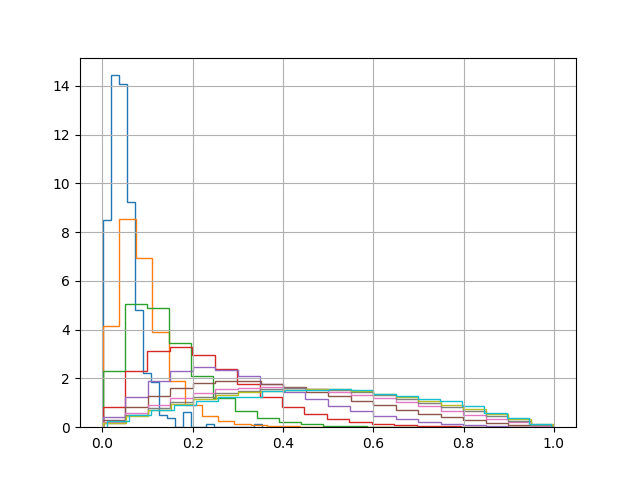

In [6]:
plt.close('all')

q_groupedby_s = haloes.groupby('s_bin')['q_scaled']
q_groupedby_s.hist( bins=20, histtype='step', normed=True );

<IPython.core.display.Javascript object>


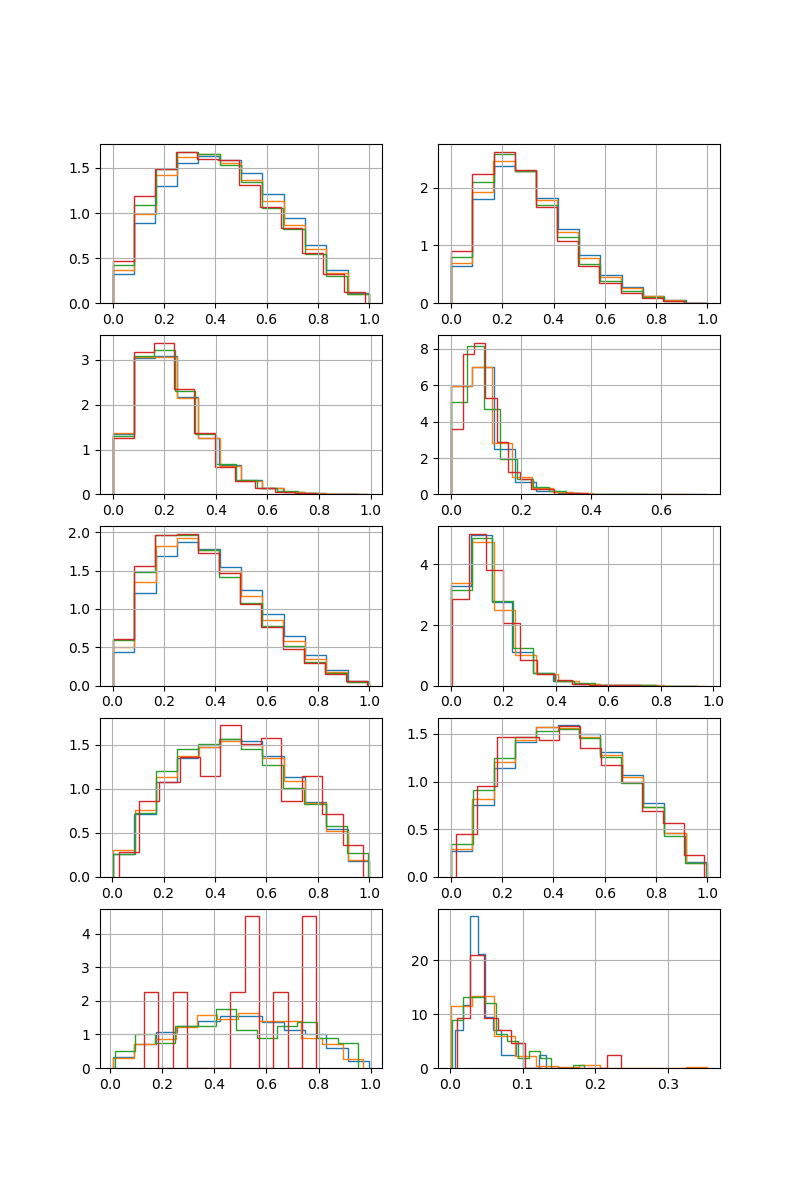

In [55]:
plt.close('all')

fig, axs = plt.subplots( nrows=5, ncols=2, figsize=( 8., 12. ) )
for s,ax in zip(haloes['s_bin'].unique(),axs.flat):
#plt.hist( haloes.query( 's_bin == @s' )['q_scaled'], bins=20, histtype='step', normed=True )

    binned = haloes.query( 's_bin == @s' )
    new_mbins = np.digitize( binned['Mvir'], 10**np.arange( 13.0, 15., 0.5 ) )
    binned.groupby(new_mbins)['q_scaled'].hist( bins=12, histtype='step',
                                                normed=True, ax=ax );

In [7]:
# Number of haloes to use
Nhaloes = 1000

#all_mass_haloes = haloes[ haloes['Mvir'] > 1e14 ].copy()

ids = np.arange( len( haloes ) )
np.random.shuffle( ids )
all_mass_haloes = haloes.iloc[ids[:Nhaloes]].copy()

In [34]:
q_linear_code = """
data {
    int<lower=0> N;          // number of haloes
    real lM[N];              // log halo mass
    real s[N];              // predicted axis ratio s
    real q[N];              // predicted axis ratio q
}
parameters {
    real<lower=-2> a_alphas;
    real<lower=0> b_alphas;
    real<lower=0> a_betas;
    real<lower=0> b_betas;
    
    real<lower=-1> a_alphaq;
    real<lower=-1> b_alphaq;
    real<upper=0> a_betaq;
    real<lower=-1> b_betaq;

}
transformed parameters {
    real<lower=0> alpha_s[N];
    real<lower=0> beta_s[N];
    
    real<lower=0> alpha_q[N];
    real<lower=0> beta_q[N];
    
    for (i in 1:N){
        alpha_s[i]= b_alphas + a_alphas * lM[i];
        beta_s[i]= b_betas + a_betas * lM[i];

        beta_q[i]= 10^(b_betaq + a_betaq * log10(s[i]));
        alpha_q[i]= 10^(b_alphaq + a_alphaq * log10(s[i]));
    }
}
model {
    s ~ beta( alpha_s, beta_s );
    q ~ beta( alpha_q, beta_q );
}
"""


q_2015_code = """
data {
    int<lower=0> N;          // number of haloes
    real lM[N];              // log halo mass
    real s[N];              // predicted axis ratio s
    real q[N];              // predicted axis ratio q
}
parameters {
    real<upper=-1> a_mus;
    real<lower=1> b_mus;
    real<lower=0> a_betas;
    real<lower=0> b_betas;
    
    real<lower=0> a_muq;
    real<lower=-1> b_muq;
    real<upper=0> a_betaq;
    real<lower=-1> b_betaq;

//    real<lower=0,upper=1> s[N];
}
transformed parameters {
    real<lower=0,upper=1> mu_s[N];
    real<lower=0> alpha_s[N];
    real<lower=0> beta_s[N];
    
    real<lower=0,upper=1> mu_q[N];
    real<lower=0> alpha_q[N];
    real<lower=0> beta_q[N];
    
    for (i in 1:N){
        mu_s[i]= b_mus + a_mus * lM[i];
        beta_s[i]= 10^( b_betas + a_betas * lM[i] );
        alpha_s[i]= beta_s[i] * mu_s[i] / ( 1. - mu_s[i] );

        mu_q[i]= b_muq + a_muq * s[i];
        beta_q[i]= 10^( b_betaq + a_betaq * log10( s[i] ) );
        alpha_q[i]= beta_q[i] * mu_q[i] / ( 1. - mu_q[i] );
    }
}
model {
    s ~ beta( alpha_s, beta_s );
    q ~ beta( alpha_q, beta_q );
}
"""


q_all_data = { 'N': len( all_mass_haloes ),
           'lM': np.log10( all_mass_haloes['Mvir'] / m_star ),
            's': all_mass_haloes['s'],
           'q': all_mass_haloes['q_scaled'], }

sm = pystan.StanModel( model_code=q_linear_code )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a94b7015fc5159e82e2d57a1b372fc89 NOW.


In [35]:
fit = sm.sampling( data=q_all_data, iter=1000, chains=1 )

In [ ]:
plt.close('all')

parameters = [ 'a_alphas', 'b_alphas', 'a_betas', 'b_betas',
                'a_alphaq', 'b_alphaq', 'a_betaq', 'b_betaq' ]

fit.traceplot( parameters );

(500, 8)


<IPython.core.display.Javascript object>


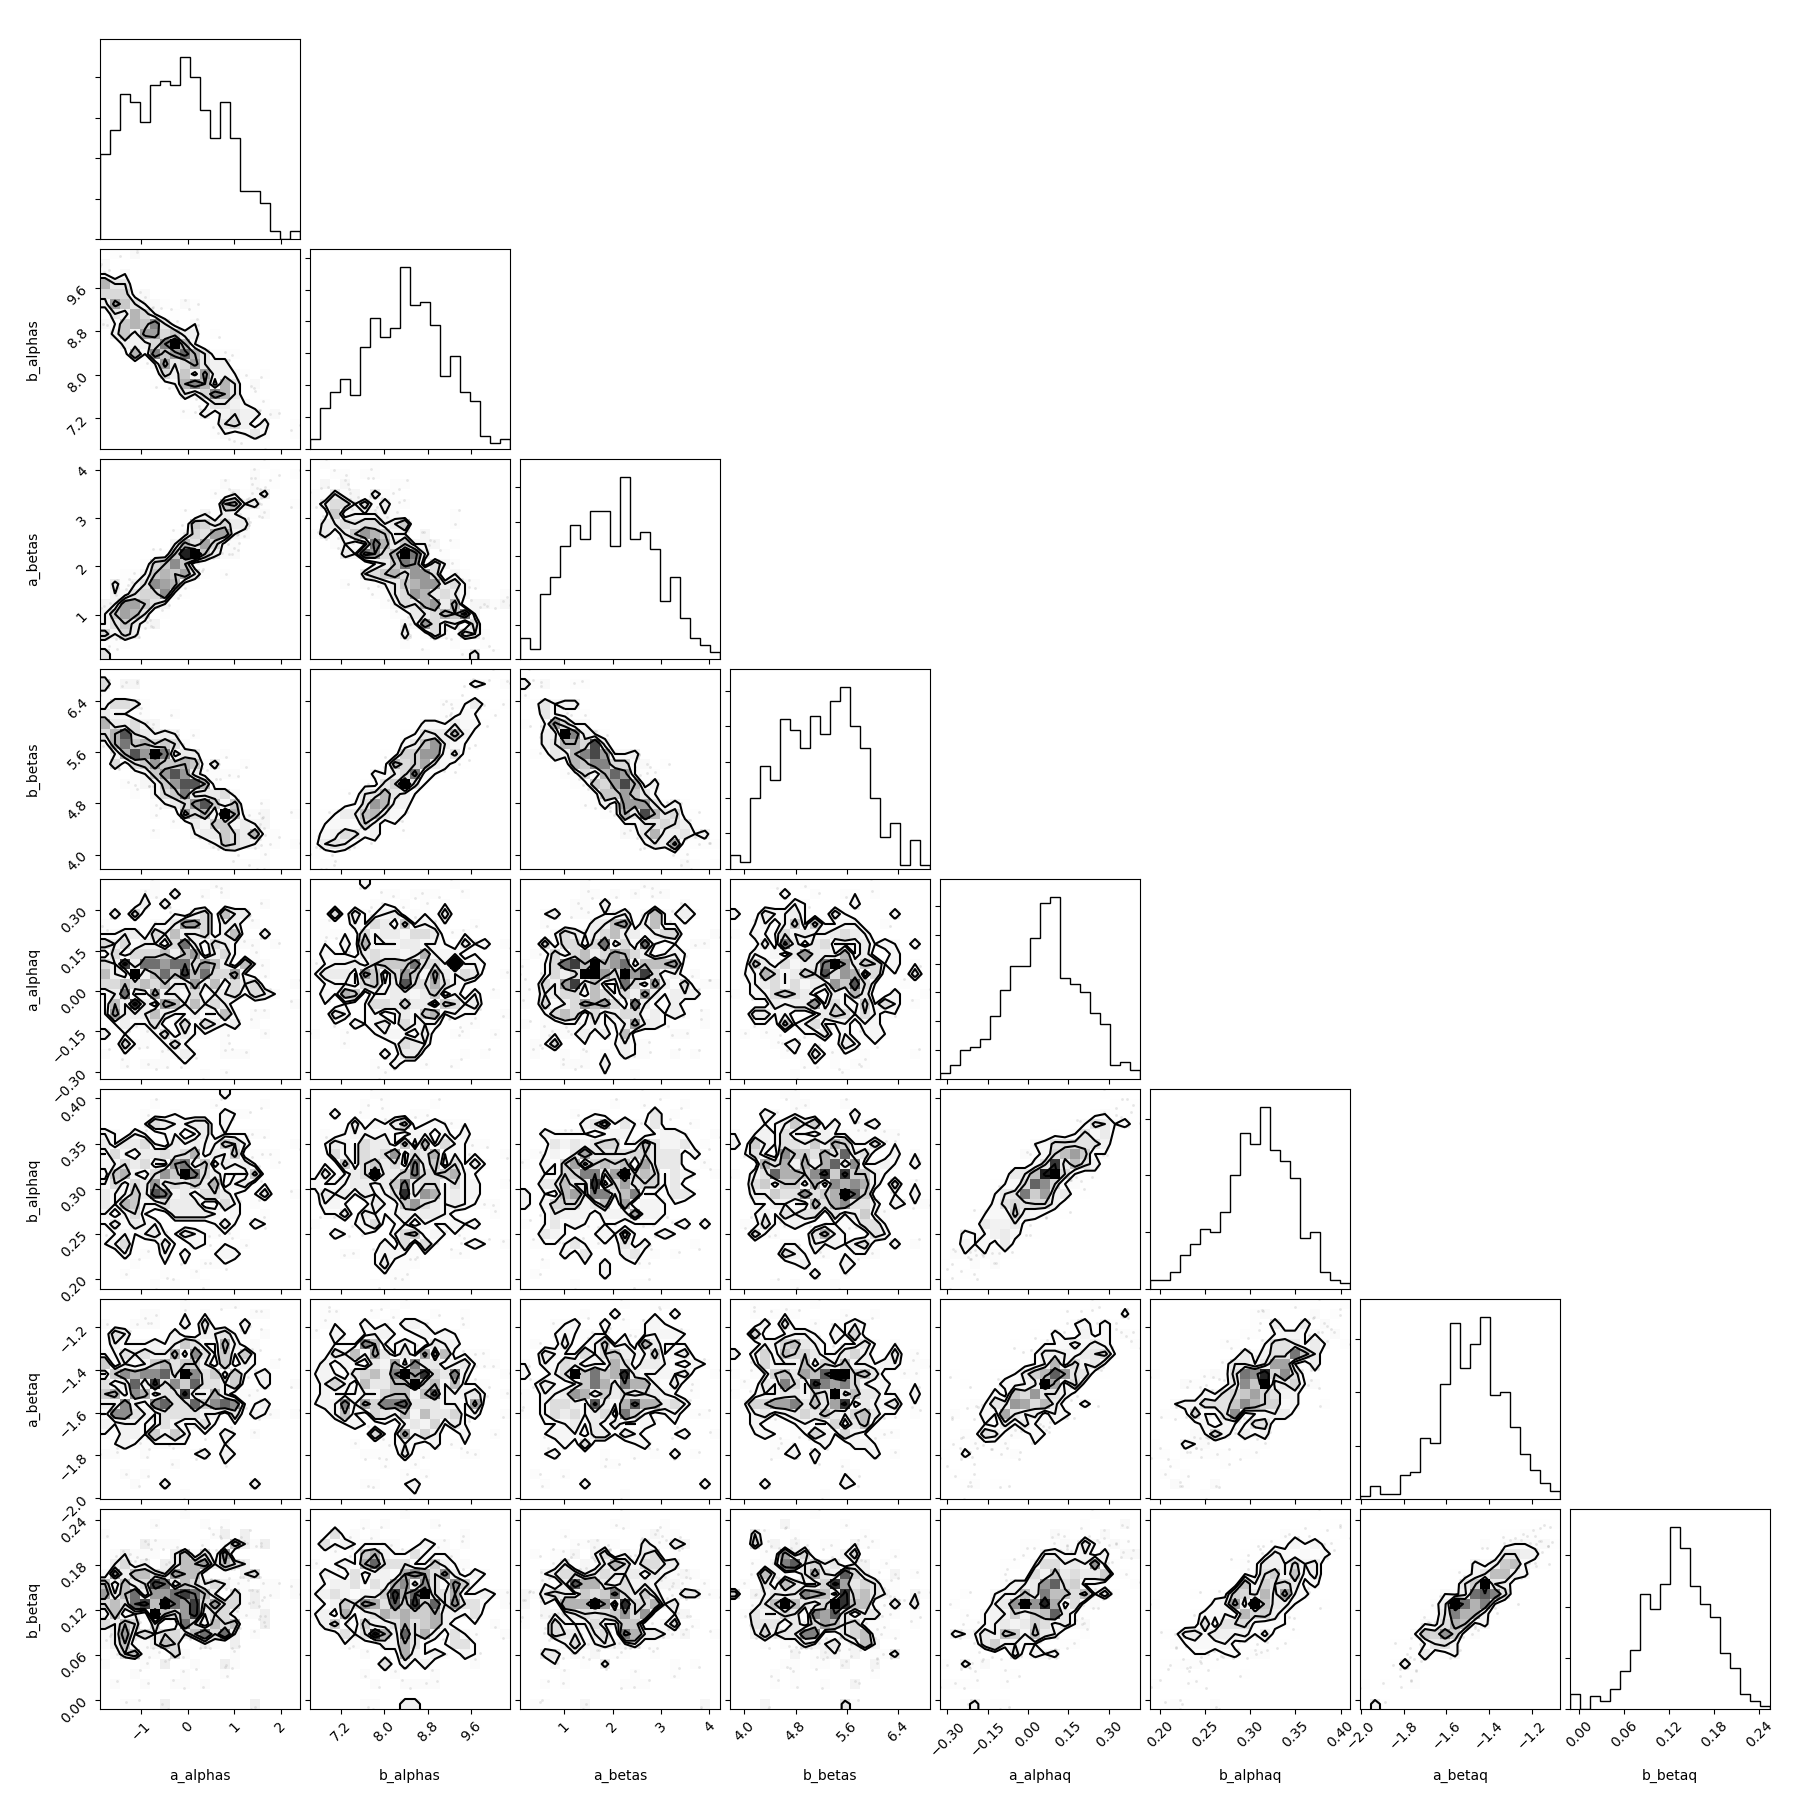

In [36]:
## return an array of three dimensions: iterations, chains, parameters
chains = fit.extract(permuted=False)
chains = chains.reshape( (-1, chains.shape[-1]) )[:,:len(parameters)]
print( chains.shape )

plt.close('all')
corner.corner( chains, labels=parameters );

In [37]:
la = fit.extract()

a_alphaq = np.median( la['a_alphaq'] )
b_alphaq = np.median( la['b_alphaq'] )
a_betaq = np.median( la['a_betaq'] )
b_betaq = np.median( la['b_betaq'] )

print( a_alphaq, b_alphaq, a_betaq, b_betaq )

0.0622575727823 0.310125431737 -1.47248311843 0.131614316518


<IPython.core.display.Javascript object>


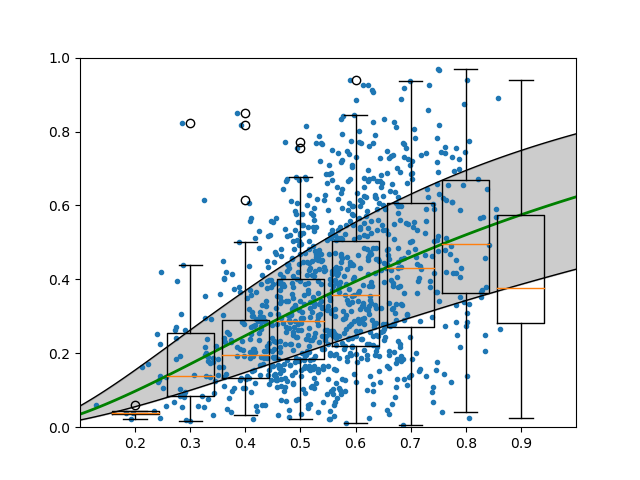

(0.1, 1.0, 0.0, 1.0)

In [38]:
plt.close('all')
import scipy.stats


xx = np.linspace( 0.1, 1, 100 )

betaq = 10**(b_betaq +  a_betaq * np.log10(xx))
alphaq = 10**(b_alphaq +  a_alphaq * np.log10(xx))
q = scipy.stats.beta( alphaq, betaq )

plt.fill_between( xx, q.ppf(0.25), q.ppf(0.75), color='k', alpha=0.2  )

plt.plot( all_mass_haloes['s'], all_mass_haloes['q_scaled'], '.' )

plt.plot( xx, q.ppf(0.5), 'g-', lw=2 )
plt.plot( xx, q.ppf(0.25), 'k-', lw=1 )
plt.plot( xx, q.ppf(0.75), 'k-', lw=1 )

xbox = [ all_mass_haloes.query( 's_bin==@s' )['q_scaled'] for s in all_mass_haloes['s_bin'].unique() ]
posbox = sbins[all_mass_haloes['s_bin'].unique()] 
plt.boxplot( xbox, positions=posbox, widths=0.085 )

plt.axis( ( 0.1, 1., 0., 1. ) )

<IPython.core.display.Javascript object>


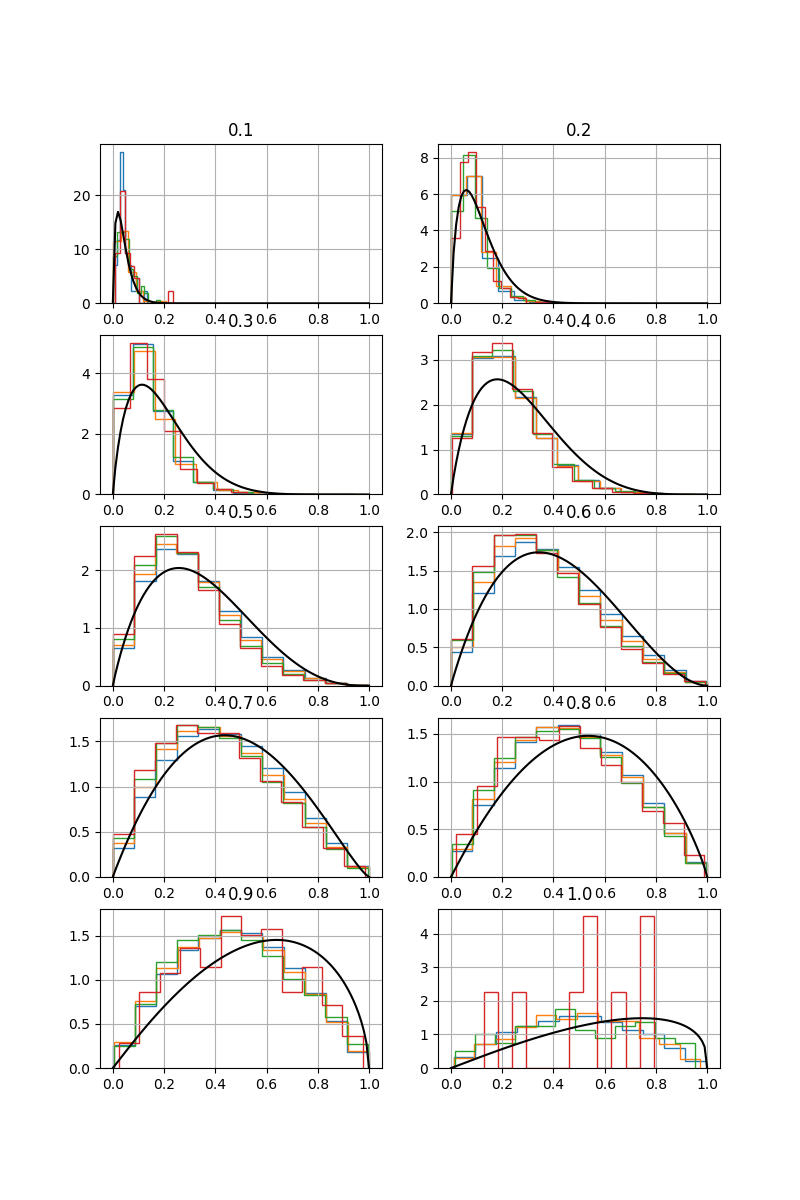

In [40]:
plt.close('all')

fig, axs = plt.subplots( nrows=5, ncols=2, figsize=( 8., 12. ) )
for s,ax in zip( sorted( haloes['s_bin'].unique() ), axs.flat ):
#plt.hist( haloes.query( 's_bin == @s' )['q_scaled'], bins=20, histtype='step', normed=True )

    binned = haloes.query( 's_bin == @s' )
    new_mbins = np.digitize( binned['Mvir'], 10**np.arange( 13.0, 15., 0.5 ) )
    binned.groupby(new_mbins)['q_scaled'].hist( bins=12, histtype='step',
                                                normed=True, ax=ax );
    betaq = 10**(b_betaq +  a_betaq * np.log10( sbins[s] ) )
    alphaq = 10**(b_alphaq +  a_alphaq * np.log10( sbins[s] ) )
    q = scipy.stats.beta( alphaq, betaq )

    xx = np.linspace( 0., 1, 100 )
    ax.plot( xx, q.pdf(xx), 'k-' )
    ax.set_title( sbins[s] )

There's still some work to do on the high values of s, but I say that we have a decent fit